### Machine Learning with Electricity Consumption Dataset Notebook
This notebook investigates the construction of a time-series forecasting model using a synthetic Electricity Consumption dataset, with the aim of predicting future electricity consumption patterns.
 
The dataset represents daily electricity consumption in San Francisco between January 1, 2024 and December 31, 2026 (adjustable via function parameters).
It is synthetic, meaning values are simulated rather than observed, but it incorporates realistic consumption dynamics, including:
- Seasonal variation (summer air conditioning demand, winter heating demand)
- Weekly cycles (weekdays vs. weekends)
- Long-term trends (growth due to electrification and population increase)
- Holiday effects (reduced consumption during holidays)
- Weather events (heat waves, cold snaps)
- Economic impacts (COVID recovery and electrification)
- Random noise to simulate natural variability

The dataset is at daily resolution.

Features in the Dataset:
- date (datetime): Calendar date of the observation.
- consumption_mw (float): Simulated daily electricity consumption in megawatts (MW). Ranges around 400–800 MW, depending on seasonal, weekly, and random factors. This is the target/endogenous variable for forecasting.
- month (int): Month of the year (1–12). Helps capture seasonality.
- year (int): Calendar year (2024–2026 in the default setup). Encodes long-term trend.
- day_of_week (int): Day of the week (0=Monday, 6=Sunday). Important for weekly consumption cycles.
- is_weekend (bool): Indicator if the date falls on Saturday or Sunday. Weekend days generally have lower electricity demand.
- is_holiday (bool): Indicator if the day is a major U.S. holiday (New Year’s Day, July 4th, Thanksgiving, Christmas). Holidays have reduced consumption.
- day_of_year (int): Ordinal day of the year (1–365/366). Useful for modeling annual seasonality.


This notebook provides a comprehensive guide to building and evaluating a forecasting model using the synthtic Electricity Consumption dataset.

### Prerequistises
Install the necessary packages

- mysql-connector-python
- pandas 
- scikit-learn
- sqlalchemy
- matplotlib

In [1]:
import os
import json
import zipfile
import shutil
import mysql.connector
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sqlalchemy

### Connect to the HeatWave instance
We create a connection to an active [HeatWave](https://www.oracle.com/mysql/) instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your HeatWave instance. On AWS, set USE_BASTION to False. On OCI, please create a tunnel on your machine using the below command by substituting the variable with their respective values

ssh -o ServerAliveInterval=60 -i BASTION_PKEY -L LOCAL_PORT:DBSYSTEM_IP:DBSYSTEM_PORT BASTION_USER@BASTION_IP

In [ ]:
BASTION_IP ="ip_address"
BASTION_USER = "opc"
BASTION_PKEY = "private_key_file"
DBSYSTEM_IP = "ip_address"
DBSYSTEM_PORT = 3306
DBSYSTEM_USER = "username"
DBSYSTEM_PASSWORD = "password"
DBSYSTEM_SCHEMA = "mlcorpus"
LOCAL_PORT = 3306
USE_BASTION = True

if USE_BASTION is True:
    DBSYSTEM_IP = "127.0.0.1"
else:
    LOCAL_PORT = DBSYSTEM_PORT

mydb = mysql.connector.connect(
    host=DBSYSTEM_IP,
    port=LOCAL_PORT,
    user=DBSYSTEM_USER,
    password=DBSYSTEM_PASSWORD,
    database=DBSYSTEM_SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = mydb.cursor()


# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

Below we use `is_holiday`, which flags major U.S. holidays, and `generate_sf_electricity_data`, which creates a synthetic daily electricity consumption dataset for San Francisco with realistic seasonal, weekly, and trend effects. 

In [3]:

def is_holiday(date):
    """Check if date is a major holiday that affects electricity consumption"""
    month = date.month
    day = date.day
    
    # Major holidays
    holidays = [
        (1, 1),   # New Year's Day
        (7, 4),   # July 4th
        (11, 24), # Thanksgiving (simplified)
        (12, 25), # Christmas
    ]
    
    return any(month == m and day == d for m, d in holidays)

def generate_sf_electricity_data(start_date='2024-01-01', end_date='2026-12-31'):
    """
    Generate synthetic electricity consumption data for San Francisco
    
    Parameters:
    start_date (str): Start date in YYYY-MM-DD format
    end_date (str): End date in YYYY-MM-DD format
    
    Returns:
    pandas.DataFrame: DataFrame with electricity consumption data
    """
    
    # Convert string dates to datetime
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Create date range
    dates = pd.date_range(start=start, end=end, freq='D')
    
    # Base consumption (MW) - SF uses about 400-600 MW average
    base_consumption = 500
    
    data = []
    
    for date in dates:
        day_of_year = date.timetuple().tm_yday
        day_of_week = date.weekday()  # 0=Monday, 6=Sunday
        month = date.month
        year = date.year
        
        # Seasonal pattern (higher in summer due to AC, and winter due to heating)
        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365.25) + \
                         0.15 * np.cos(4 * np.pi * day_of_year / 365.25)
        
        # Weekly pattern (lower on weekends)
        weekly_factor = 0.85 if day_of_week >= 5 else 1.0  # Saturday=5, Sunday=6
        
        # Long-term trend (increase over years due to population growth and electrification)
        trend_factor = 1 + (year - 2022) * 0.025
        
        # Holiday effects (reduced consumption on major holidays)
        holiday_factor = 0.7 if is_holiday(date) else 1.0
        
        # Random noise
        noise = 1 + (np.random.random() - 0.5) * 0.1
        
        # Weather variations (more extreme in summer/winter)
        weather_factor = 1 + (np.random.random() - 0.5) * 0.2 * \
                        abs(np.sin(2 * np.pi * day_of_year / 365.25))
        
        # Special weather events
        special_event_factor = 1.0
        
        # Heat waves (summer peaks)
        if 6 <= month <= 8 and np.random.random() < 0.05:
            special_event_factor = 1.4  # 40% increase during heat waves
        
        # Cold snaps (winter peaks)
        if month in [12, 1, 2] and np.random.random() < 0.03:
            special_event_factor = 1.25  # 25% increase during cold snaps
        
        # Economic impacts (post-COVID patterns)
        economic_factor = 1.0
        if year == 2022:
            economic_factor = 0.98  # Slight reduction due to remote work continuation
        elif year == 2023:
            economic_factor = 1.02  # Recovery and return to office
        elif year >= 2024:
            economic_factor = 1.01  # Steady growth with increased electrification
        
        # Calculate final consumption
        consumption = base_consumption * seasonal_factor * weekly_factor * \
                     trend_factor * holiday_factor * noise * weather_factor * \
                     special_event_factor * economic_factor
        
        data.append({
            'date': date,
            'consumption_mw': round(consumption, 1),
            'month': month,
            'year': year,
            'day_of_week': day_of_week,
            'is_weekend': day_of_week >= 5,
            'is_holiday': is_holiday(date),
            'day_of_year': day_of_year
        })
    
    return pd.DataFrame(data)

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate the synthetic dataset
df = generate_sf_electricity_data()
df

,date,consumption_mw,month,year,day_of_week,is_weekend,is_holiday,day_of_year
0,2024-01-01,424.0,1,2024,0,False,True,1
1,2024-01-02,619.7,1,2024,1,False,False,2
2,2024-01-03,592.5,1,2024,2,False,False,3
3,2024-01-04,628.7,1,2024,3,False,False,4
4,2024-01-05,639.8,1,2024,4,False,False,5
...,...,...,...,...,...,...,...,...
1091,2026-12-27,525.0,12,2026,6,True,False,361
1092,2026-12-28,610.2,12,2026,0,False,False,362
1093,2026-12-29,647.6,12,2026,1,False,False,363
1094,2026-12-30,665.5,12,2026,2,False,False,364


### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [5]:
# Time-based split
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=False)

 ### Load the Electricity Consumption dataset into a HeatWave table
 We connect to the MySQL database using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (electricity_consumption_train and electricity_consumption_test) in the database, replacing any existing tables.

In [7]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{DBSYSTEM_USER}:{DBSYSTEM_PASSWORD}@{DBSYSTEM_IP}:{LOCAL_PORT}/{DBSYSTEM_SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'electricity_consumption_train' table in the database
df_train.to_sql(
    f"electricity_consumption_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)
# Write the testing DataFrame to the 'electricity_consumption_test' table in the database
df_test.to_sql(
    f"electricity_consumption_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)

329

### Create a HeatWave AutoML Forecasting Model from the Electricity Consumption Dataset
In this section, we will train a time-series forecasting model using HeatWave AutoML’s [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) routine on the Electricity Consumption dataset. The objective is to predict future electricity consumption based on historical data, leveraging HeatWave AutoML's advanced automated facilities for time-series modeling.

We specify electricity consumption (e.g., load in mW) as the endogenous variable, enabling HeatWave AutoML to automatically detect temporal patterns—such as trend and seasonality—and forecast upcoming load values.

A model is then generated and is stored in the model catalog and can be used for forecasting tasks. 

In [8]:
endogenous_column = 'consumption_mw'
datetime_index_column = 'date'

execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{DBSYSTEM_SCHEMA}.electricity_consumption_train', NULL, JSON_OBJECT('task', 'forecasting', 'datetime_index', '{datetime_index_column}',
    'endogenous_variables', JSON_ARRAY('{endogenous_column}')), @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine. It allows us to quantify the quality of the predictions. The user needs to provide which metrics he wants to use. 

In [9]:
endogenous_column = 'consumption_mw'
execute_sql(
    f"""CALL sys.ML_SCORE('{DBSYSTEM_SCHEMA}.electricity_consumption_test', '{endogenous_column}', '{model}', 'neg_sym_mean_abs_percent_error', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model score is {score:.2f}")

The model score is -0.23


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains an extra column ml_results which contains the forecast for endogenous variables.

In [10]:
execute_sql(f"""DROP TABLE IF EXISTS electricity_consumption_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{DBSYSTEM_SCHEMA}.electricity_consumption_test', '{model}', '{DBSYSTEM_SCHEMA}.electricity_consumption_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT date, consumption_mw, ml_results FROM electricity_consumption_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS electricity_consumption_test_predictions""")
df_predictions

,date,consumption_mw,ml_results
0,2026-02-06,680.6,"{""predictions"": {""consumption_mw"": 696.8543910..."
1,2026-02-07,547.0,"{""predictions"": {""consumption_mw"": 590.7202080..."
2,2026-02-08,586.8,"{""predictions"": {""consumption_mw"": 579.3440885..."
3,2026-02-09,698.5,"{""predictions"": {""consumption_mw"": 696.5576745..."
4,2026-02-10,638.4,"{""predictions"": {""consumption_mw"": 691.8181181..."
...,...,...,...
324,2026-12-27,525.0,"{""predictions"": {""consumption_mw"": 523.8081714..."
325,2026-12-28,610.2,"{""predictions"": {""consumption_mw"": 628.8918536..."
326,2026-12-29,647.6,"{""predictions"": {""consumption_mw"": 625.9939143..."
327,2026-12-30,665.5,"{""predictions"": {""consumption_mw"": 622.9372806..."


### Getting a deeper understanding of the model's predictions

Next, we visualize the electricity consumption data alongside the model forecasts.

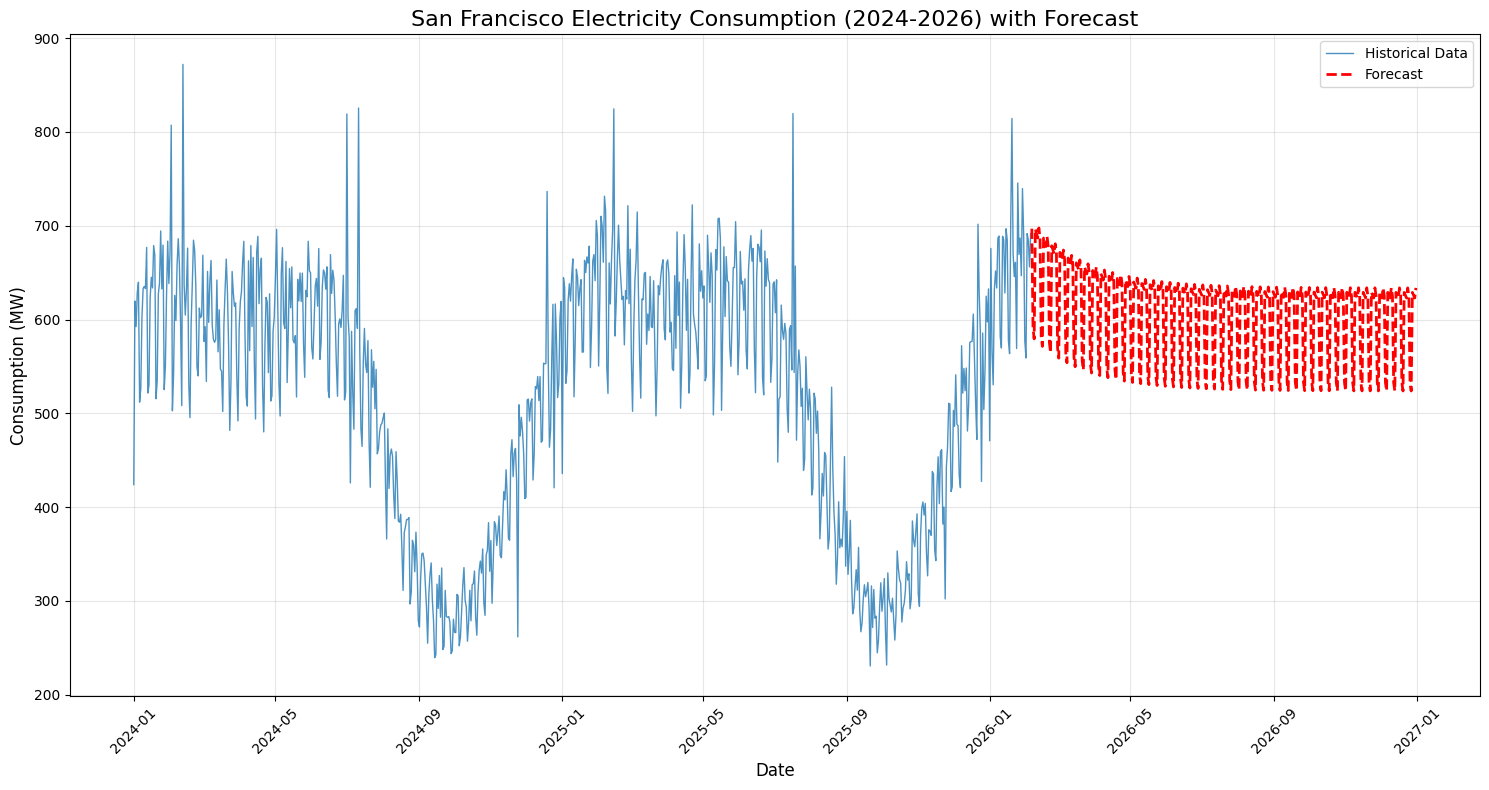

In [11]:
forecasted_consumption_mw = df_predictions['ml_results'].apply(json.loads).apply(lambda x: x["predictions"]["consumption_mw"]).apply(pd.Series).values
df_predictions['forecast_mw']=forecasted_consumption_mw

def plot_data_and_forecast(historical_data, forecast_data=None):
    """
    Plot historical data and optional forecast
    
    Parameters:
    historical_data (pandas.DataFrame): Historical consumption data
    forecast_data (pandas.DataFrame): Optional forecast data
    """
    
    plt.figure(figsize=(15, 8))
    
    # Plot historical data
    plt.plot(historical_data['date'], historical_data['consumption_mw'], 
             label='Historical Data', linewidth=1, alpha=0.8)
    
    # Plot forecast if provided
    if forecast_data is not None:
        plt.plot(forecast_data['date'], forecast_data['forecast_mw'], 
                 label='Forecast', linewidth=2, linestyle='--', color='red')
    
    plt.title('San Francisco Electricity Consumption (2024-2026) with Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Consumption (MW)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_data_and_forecast(df_train, df_predictions)